# Morning: Introduction to Time Series Analysis

First we import the requried packages. Note we also need to load the required R packages using *importr*.

In [1]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
stats = importr('stats')

## Is there a trend?

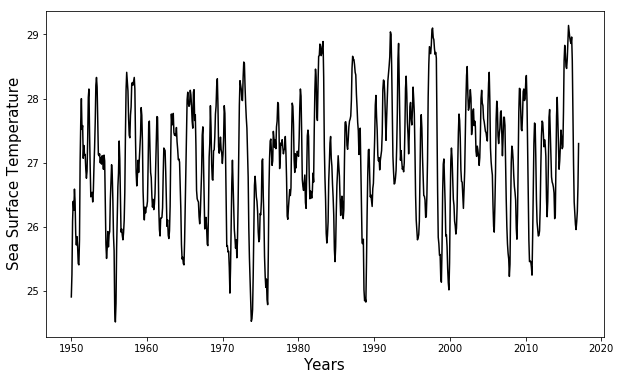

In [2]:
sst = np.loadtxt('../Data/detrend.nino34.ascii.txt',skiprows=1) # Get El Nino data from file (included in repository)
y = sst[:,2]                                      # Extract SST measurements
t1 = np.linspace(1950,2017,len(y))                # Define time axis

#-- Plot time-series
fig = plt.figure(figsize=(10,6))                  # Set up figure
plt.plot(t1,y,'k-')                               # Plot SST as a line
plt.ylabel('Sea Surface Temperature',fontsize=15) #label y-axis
plt.xlabel('Years',fontsize=15)                   #label x-axis
plt.show()

In [3]:
robjects.globalenv["y"] = robjects.FloatVector(y)   # Add y to the R environmental as a FloatVector R object
robjects.globalenv["t1"] = robjects.FloatVector(t1) # Add y to the R environmental as a FloatVector R object
fit = r.lm("y ~ t1")                                # linear fit with model y ~ t1
#return summary of fit, including everything after the word "Resduals" to avoid the long "call" information.
print str(r.summary(fit))[str(r.summary(fit)).find("Residuals:"):]  

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4020 -0.6441  0.0608  0.6246  1.9709 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.688845   3.290339   3.249  0.00121 ** 
t1           0.008230   0.001659   4.961 8.55e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9125 on 805 degrees of freedom
Multiple R-squared:  0.02967,	Adjusted R-squared:  0.02846 
F-statistic: 24.61 on 1 and 805 DF,  p-value: 8.551e-07




## Generate sample realizations

The code below generates sample realizations of the stochastic process defined by the `r.rnorm()` command. The `rnorm(n,mean,sd)` takes the size of the realization as its first arguement, the mean of the normal distribution as its second, and the standard deviation as its third.

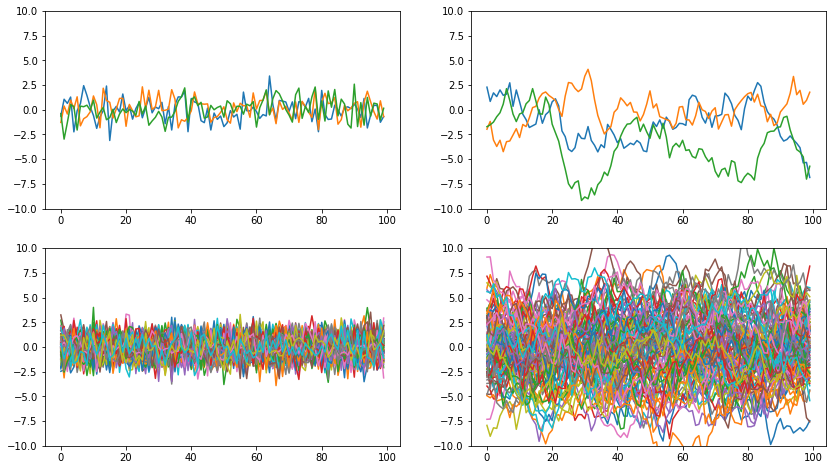

In [4]:
fig, ax = plt.subplots(2,2,figsize=(14,8)) # Set up figure and subplots
#-- 3 sample realizations
for i in range(3):
    ax[0,0].plot(np.array(r.rnorm(100)))  # purely random process;
    # autoregressive model with autoregressive coefficient 0.95
    ax[0,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95})))) 
    ax[0,0].set_ylim([-10,10])            # y range for first plot 
    ax[0,1].set_ylim([-10,10])            # y range for second plot
#-- Same as above but with 100 sample realizations
for i in range(100):
    ax[1,0].plot(np.array(r.rnorm(100)))  
    ax[1,1].plot(np.array(stats.arima_sim(100,model=robjects.ListVector({'ar':0.95}))))
    ax[1,0].set_ylim([-10,10])
    ax[1,1].set_ylim([-10,10])
plt.show()

## The autocorrelation function

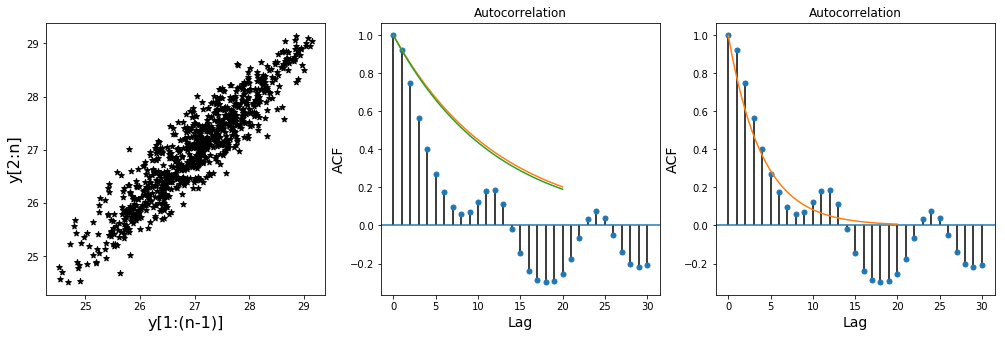

In [6]:
fig, ax = plt.subplots(1,3,figsize=(17,5))            # Set up figure and subplots
ax[0].scatter(y[:-1],y[1:],color='k',marker='*')      # scatter plot of values shifted by 1
ax[0].set_xlabel('y[1:(n-1)]',fontsize=16)            # x axis label
ax[0].set_ylabel('y[2:n]',fontsize=16)                # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[1]) # plot empirical autocorrelation function
alpha_hat1 = np.corrcoef(y[:-1],y[1:])[0,1]           # the correlation coefficient between lagged values
robjects.globalenv["y_shifted1"] = robjects.FloatVector(y[1:])     # add 2nd to last y values to R environment
robjects.globalenv["y_shifted2"] = robjects.FloatVector(y[:-1])    # add 1st to second-last y values to R environment
alpha_hat2 = r.lm("y_shifted1 ~ y_shifted2").rx2('coefficients')[1]# the linear slope between lagged values
ax[1].plot(np.linspace(0,20),alpha_hat1**np.linspace(0,20))        # line for theoretical acf using correlation coeff
ax[1].plot(np.linspace(0,20),alpha_hat2**np.linspace(0,20))        # add line for threoretical acf using slope
ax[1].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[1].set_ylabel('ACF',fontsize=14)                   # y axis label
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[2]) # plot empirical autocorrelation function
ax[2].plot(np.linspace(0,20),0.78**np.linspace(0,20)) # plot optimized autocorrelation function (more info below)
ax[2].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[2].set_ylabel('ACF',fontsize=14)                   # y axis label
plt.show()

## Generate various time series structures

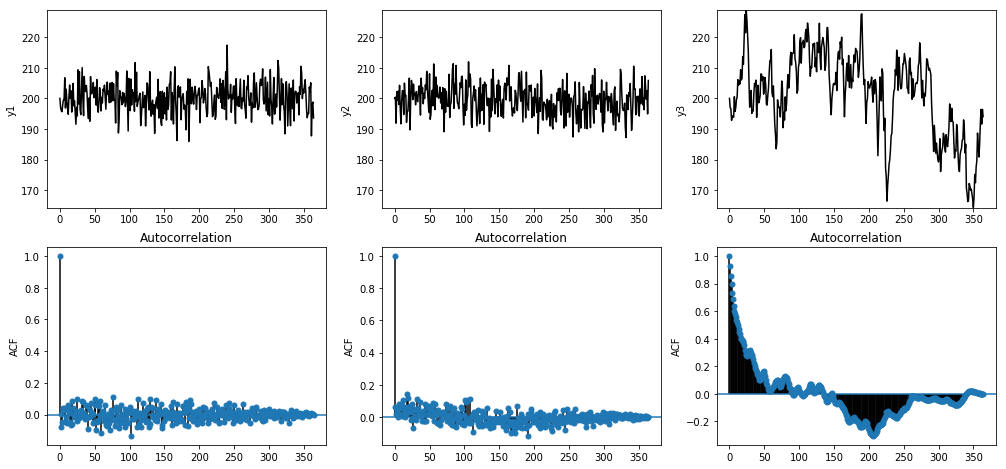

In [6]:
y0 = 20                             # intercept value
a = 0.9                             # autocorrelation/autoregressive parameter
s = 5                               # standard deviation of the random increments
b = 1                               # amplitude of the seasonal cycle
nyrs = 1                            # number of years in the simulation
T = nyrs*365                        # number of days
f  = np.linspace(0,2*np.pi*nyrs,T)  # nyrs cycles over the number of days T [radians]
sinf = np.sin(f)                    # sine wave
y1, y2, y3 = np.array([200]),np.array([200]),np.array([200])     # initial values
for i in range(1,T):
    y1t1 = y1[0] + np.array(r.rnorm(1,0,s))                      # 'purely random process' (PRP)
    y2t1 = y2[0] + np.array(r.rnorm(1,0,s)) + b*sinf[i]          # PRP with seasonal component
    y3t1 = y0 + np.array(r.rnorm(1,0,s)) + b*sinf[i] + a*y3[i-1] # PRP with seasonal component and autocorrelation
    y1 = np.concatenate((y1,y1t1))                        # extend the time series with new values
    y2 = np.concatenate((y2,y2t1))
    y3 = np.concatenate((y3,y3t1)) 
fig, ax = plt.subplots(2,3,figsize=(17,8))                # Set up figure and panels
y_max = np.max([y1.max(),y2.max(),y3.max()])              # Get maximum range of y-axis
y_min = np.min([y1.min(),y2.min(),y3.min()])              # Get minimum range of y-axis
for i,yi,lbl in zip(range(3),[y1,y2,y3],['y1','y2','y3']):# Loop over axes and plot the time-series
    ax[0,i].plot(yi,'k-')                                 # plot line
    ax[0,i].set_ylim([y_min,y_max])                       # set y axis range
    ax[0,i].set_ylabel(lbl)                               # y axis label
for i,yi in zip(range(3),[y1,y2,y3]):                     # Loop & plot empirical autocorrelation function
    sm.graphics.tsa.plot_acf(yi,lags=T-1,alpha=np.float('nan'),ax=ax[1,i])
    ax[1,i].set_ylabel('ACF')                             # y axis label
plt.show()

## Simple trend analysis with autocorrelation

In [7]:
# Fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. 
# Specify method='ML' to fit exact maximum likelihood
print r.summary(nlme.gls(r.formula("y ~ t1"), correlation=nlme.corAR1()))

Generalized least squares fit by REML
  Model: y ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  637.1089 655.8723 -314.5545

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9272067 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 5.816964 16.795079 0.3463493  0.7292
t1          0.010672  0.008467 1.2603950  0.2079

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4783251 -0.6540165  0.1030884  0.6908156  2.0707585 

Residual standard error: 0.9484359 
Degrees of freedom: 807 total; 805 residual



# ------------------------- MORNING BREAK ------------------------------

# Analysis of Orange Country ozone time series

# Simple trend analysis

In [8]:
d = pd.read_csv('../Data/ozone_orange.csv')      # Read Ozone data from CSV file
ind = np.nonzero(d['year']!=2016)                # Get indices for data before 2016 for simplicity
y1 = np.array(d['ozone'])[ind]                   # Extract ozone data
years = np.array(d['year'])[ind]                 # Extract years
t1 = np.linspace(years.min(),years.max(),len(y1))#define time axis

In [9]:
robjects.globalenv["y1"] = robjects.FloatVector(y1) # Add y1 to R envrionment as FloatVector
robjects.globalenv["t1"] = robjects.FloatVector(t1) # Add y1 to R envrionment as FloatVector
#-- display the summary of a fitted regression with autoregressive covariance matrix
print r.summary(nlme.gls(r.formula("y1 ~ t1"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y1 ~ t1 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t1          -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual



# Harmonic regression

In [10]:
nyrs= years.max() - years.min()         # number of seasonal cycles [years]
f = np.linspace(0,2*np.pi*nyrs,len(y1)) # nyrs cycles over the length of the time series [radians]
sinf = np.sin(f)                        # sine wave of f
cosf = np.cos(f)                        # cose wave of f

In [11]:
robjects.globalenv["sinf"] = robjects.FloatVector(sinf) # Add sine to R envrionment as FloatVector
robjects.globalenv["cosf"] = robjects.FloatVector(cosf) # Add cose to R envrionment as FloatVector
#-- fit regression with seasonal component and first order autoregressive covariance matrix
print r.summary(nlme.gls(r.formula("y1 ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML'))

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual



# Time series decomposition

In [12]:
# store the model object from the fit above
fit = nlme.gls(r.formula("y1 ~ sinf + cosf + t1"), correlation=nlme.corAR1(),method='ML')

In [13]:
k_hat = fit.rx2('coefficients')          # extract fitted regression coefficients
print k_hat                              # Display for comparison with R
k_hat_var = np.array(fit.rx2('varBeta')) # extract the associated errors
print k_hat_var                          # Display for comparison with R
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False) #extract fitted autoregressive parameter
e = np.array(fit.rx2('residuals'))       #extract 'raw' residuals (yi - ypred) 

  (Intercept)          sinf          cosf            t1 
-8.728852e-03  8.972455e-04  1.082647e-02  1.726393e-05 

[[  1.51555016e-01  -2.39327705e-05  -1.27465230e-09  -7.55695647e-05]
 [ -2.39327705e-05   5.09997235e-07  -1.55858674e-19   1.19335679e-08]
 [ -1.27465230e-09  -1.55858674e-19   5.03681416e-07  -4.92254945e-19]
 [ -7.55695647e-05   1.19335679e-08  -4.92254945e-19   3.76811591e-08]]


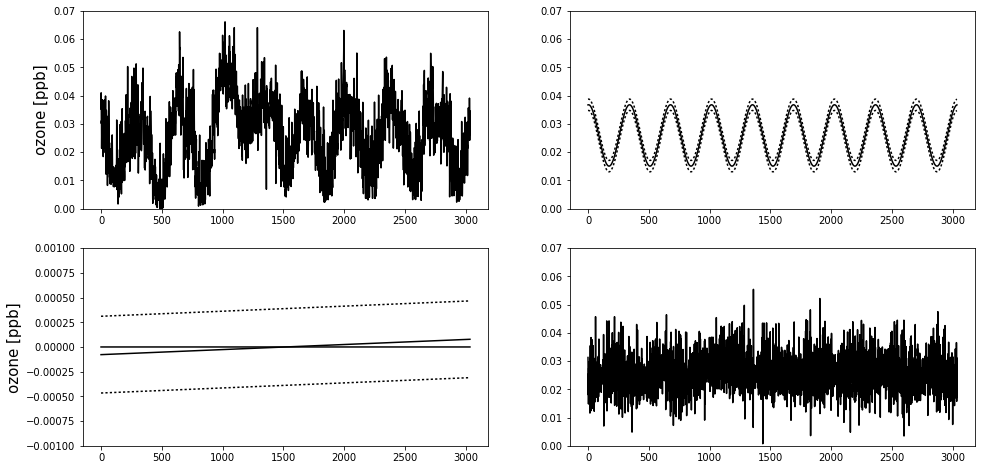

In [14]:
#-- Plot results
fig, ax = plt.subplots(2,2,figsize=(16,8))    # set up figure and panels
ax[0,0].plot(y1,'k-')                         # plot the data
ax[0,0].set_ylim([0,0.07])                    # y axis range
ax[0,0].set_ylabel('ozone [ppb]',fontsize=15) # y axis label

f_hat = np.mean(y1) + k_hat[1]*sinf + k_hat[2]*cosf  # fitted seasonal cycle
ax[0,1].plot(f_hat,'k-')                             # plot fitted seasonal cycle
#-- add 95% CIs (upper and lower); note the variance is already std^2
ax[0,1].plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') 
ax[0,1].plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax[0,1].set_ylim([0,0.07])                           # y axis range

t_hat = k_hat[0] + k_hat[3]*t1                       # fitted trend
t_hat -= np.mean(t_hat)                              # normalize to the zero-line
ax[1,0].plot(t_hat,'k-')                             # plot fitted trend
ax[1,0].plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:') # upper 95% CI
ax[1,0].plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:') # lower  95% CI
ax[1,0].plot(np.zeros(len(t_hat)),'k-')              # add 0 line 
ax[1,0].set_ylabel('ozone [ppb]',fontsize=15)        # y axis label
ax[1,0].set_ylim([-0.001,0.001])                     # y axis range

ear = e[1:]-phi_hat*e[:-1]                    # subtract the autoregression
ax[1,1].plot(np.mean(y1)+ear,'k-')            # plot the residuals
ax[1,1].set_ylim([0,0.07])                    # y axis range
plt.show()

# Time series regression

In [15]:
x1 = np.array(d['temp'])[ind]    # Extract temperature
x2 = np.array(d['windsp'])[ind]  # Extract wind speed
x3 = np.array(d['winddir'])[ind] # Extract wind direction
robjects.globalenv["x1"] = robjects.FloatVector(x1)# Add temp to R environment as a FloatVector
robjects.globalenv["x2"] = robjects.FloatVector(x2)# Add wind speed to R environment as a FloatVector
robjects.globalenv["x3"] = robjects.FloatVector(x3)# Add wind dir to R environment as a FloatVector
#-- fit regression with seasonal terms, one input, with autoregressive correlation matrix  
fitx1 = nlme.gls(r.formula("y1 ~ sinf + cosf + x1"), correlation=nlme.corAR1(),method='ML')
print r.summary(fitx1)           # Display summary of the fitted model

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error   t-value p-value
(Intercept) 0.024437725 0.0021696121 11.263638  0.0000
sinf        0.000793210 0.0007218835  1.098807  0.2719
cosf        0.010728155 0.0007200955 14.898239  0.0000
x1          0.000022837 0.0000331050  0.689847  0.4903

 Correlation: 
     (Intr) sinf   cosf  
sinf  0.193              
cosf  0.192  0.039       
x1   -0.973 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual



In [16]:
# Fit linear regression with seasonal cycle and 3 independent variables; via maximum likelihood method='ML'
fitx123 = nlme.gls(r.formula("y1 ~ sinf + cosf + x1 + x2 + x3"), correlation=nlme.corAR1(),method='ML')
print r.summary(fitx123)  # Display the summary of the model

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 + x2 + x3 
  Data: NULL 
     AIC       BIC  logLik
  -22611 -22562.85 11313.5

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7868927 

Coefficients:
                   Value    Std.Error   t-value p-value
(Intercept)  0.020406707 0.0021083140  9.679159  0.0000
sinf         0.001603743 0.0007131025  2.248965  0.0246
cosf         0.010199741 0.0007180072 14.205625  0.0000
x1          -0.000111914 0.0000307147 -3.643677  0.0003
x2           0.002810266 0.0001128399 24.904898  0.0000
x3           0.000016128 0.0000034484  4.676984  0.0000

 Correlation: 
     (Intr) sinf   cosf   x1     x2    
sinf  0.179                            
cosf  0.215  0.039                     
x1   -0.895 -0.189 -0.177              
x2   -0.087  0.044 -0.032 -0.166       
x3   -0.324 -0.037 -0.152 -0.012  0.190

Standardized residuals:
        Min          Q1         Med          Q3         Max 

# Model Selection

In [17]:
# Dictonary of models (model labels,percent varation explained by the predictions (R2),
# Bayesian information criterion (BIC), number of parameters in the models (k))
df = pd.DataFrame(data={
    'model':['fitx1','fitx123'],
    'R2':[(np.corrcoef(y1,r.predict(fitx1))[0,1])**2,(np.corrcoef(y1,r.predict(fitx123))[0,1])**2], 
    'BIC':[np.squeeze(r.summary(fitx1).rx2('BIC')),np.squeeze(r.summary(fitx123).rx2('BIC'))],
    'k':[np.squeeze(r.summary(fitx1).rx2('dims').rx2('p')),np.squeeze(r.summary(fitx123).rx2('dims').rx2('p'))]}, 
                  columns=['model','R2','BIC','k'])
df #Display

,model,R2,BIC,k
0,fitx1,0.374044,-22015.8735833,4
1,fitx123,0.442016,-22562.8512809,6


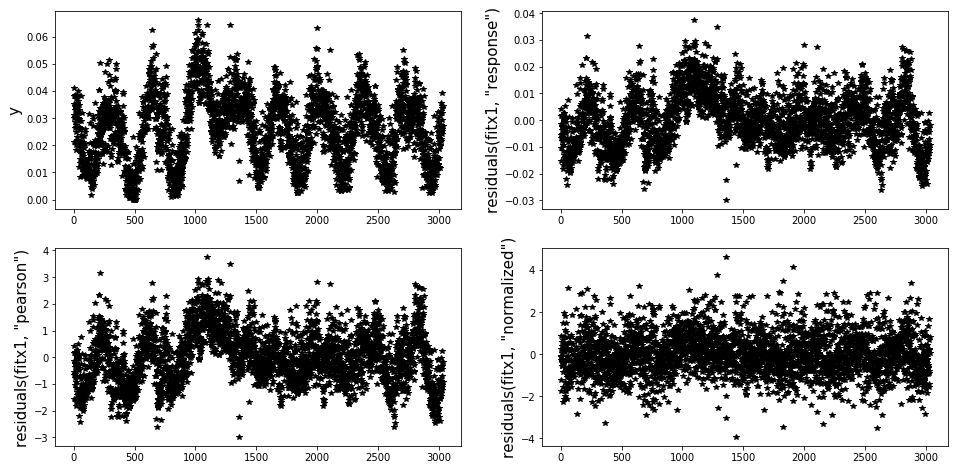

In [18]:
fig, ax = plt.subplots(2,2,figsize=(16,8))          # Set up figure and panels
ax[0,0].plot(y1,'k*')                               # plot data
ax[0,0].set_ylabel('y',fontsize=15)                 # y label
ax[0,1].plot(r.residuals(fitx1, 'response'),'k*')   # 'raw' residuals
ax[0,1].set_ylabel('residuals(fitx1, "response")',fontsize=15) 
ax[1,0].plot(r.residuals(fitx1, 'pearson'),'k*')    # normalized to have unit variance
ax[1,0].set_ylabel('residuals(fitx1, "pearson")',fontsize=15) 
ax[1,1].plot(r.residuals(fitx1, 'normalized'),'k*') #residuals after removing the autocorrelation
ax[1,1].set_ylabel('residuals(fitx1, "normalized")',fontsize=15)
plt.show()